In [1]:
import pyspark
import os
import json
import argparse

from dotenv import load_dotenv
from pathlib import Path
from pyspark.sql.types import StructType,IntegerType,StringType
from pyspark.sql import functions as f
from pyspark.sql.functions import (col, 
                                   udf, 
                                   pandas_udf,
                                   to_timestamp,
                                   col,
                                   when,
                                   to_date,
                                   year, 
                                   month,
                                   dayofmonth, 
                                   hour, 
                                   quarter, 
                                   date_format,
                                   dayofweek,
                                   datediff,
                                   trunc,
                                   asc,
                                  desc,
                                  corr,
                                   round,
                                  min,
                                   sum,
                                   max,
                                  countDistinct,
                                   collect_set
                                  )
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dotenv_path = Path('/resources/.env')
load_dotenv(dotenv_path=dotenv_path)

True

In [3]:
postgres_host = os.getenv('DIBIMBING_DE_POSTGRES_HOST')
postgres_db = os.getenv('DIBIMBING_DE_POSTGRES_DB')
postgres_user = os.getenv('DIBIMBING_DE_POSTGRES_ACCOUNT')
postgres_password = os.getenv('DIBIMBING_DE_POSTGRES_PASSWORD')

In [4]:
sparkcontext = pyspark.SparkContext.getOrCreate(conf=(
        pyspark
        .SparkConf()
        .setAppName('Dibimbing')
        .setMaster('local')
        .set("spark.jars", "/opt/postgresql-42.2.18.jar")
    ))
sparkcontext.setLogLevel("WARN")

spark = pyspark.sql.SparkSession(sparkcontext.getOrCreate())

In [5]:
spark

In [6]:
jdbc_url = f'jdbc:postgresql://{postgres_host}/{postgres_db}'
jdbc_properties = {
    'user': postgres_user,
    'password': postgres_password,
    'driver': 'org.postgresql.Driver',
    'stringtype': 'unspecified'
}

In [7]:
retail_df = spark.read.jdbc(
    jdbc_url,
    'public.retail',
    properties=jdbc_properties
)

retail_df.createOrReplaceTempView("retail_data")

In [8]:
#Show Data
spark.sql("""
 select * from retail_data
""").show()

+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|invoiceno|stockcode|         description|quantity|invoicedate|unitprice|customerid|       country|
+---------+---------+--------------------+--------+-----------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6| 2010-12-01|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8| 2010-12-01|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6| 2010-12-01|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2| 2010-12-01|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6| 2010-12-01|     4.25|     17850|United Kingdom|


# Data Cleaning

In [9]:
# Apakah terdapat Revenue yang negatif ?
spark.sql('''
          select min(quantity * unitprice) as revenue
          from retail_data
          having revenue < 0
          ''').show()

+---------+
|  revenue|
+---------+
|-168469.6|
+---------+



As expected, there is negative revenue, which may be due to customer cancellations. The analyzed data only includes revenue greater than zero. <br>

Furthermore, we will examine if there are any entries containing the code "C" as an indication of cancellations. <br>

Business Insight: The presence of negative revenue suggests that some customers have canceled their orders. It is crucial to identify the reasons behind these cancellations and take appropriate measures to mitigate their impact. By analyzing the data and identifying entries with the code "C," we can gain further insights into the cancellation patterns and devise strategies to minimize future cancellations.

In [10]:
spark.sql('''
          select distinct(invoiceno)
          from retail_data
          where invoiceno like("%C%")
          ''').show()

+---------+
|invoiceno|
+---------+
|  C540850|
|  C542604|
|  C546174|
|  C549913|
|  C550672|
|  C556414|
|  C562959|
|  C576393|
|  C577362|
|  C578132|
|  C540347|
|  C542245|
|  C548738|
|  C550614|
|  C552015|
|  C552019|
|  C552919|
|  C553370|
|  C557154|
|  C557654|
+---------+
only showing top 20 rows



From the collected data, it appears that there is a mix of entries with InvoiceNo containing "C." Therefore, it is necessary to clean the data by removing these entries before proceeding with exploration. <br>

Data cleaning is an essential step in the analysis process. By removing entries with "C" in the InvoiceNo, we can ensure that our exploration is based on accurate and reliable data. This will enable us to gain meaningful insights and make informed business decisions based on a clean dataset.






In [11]:
df = spark.sql('''
    select 
        invoiceno,
        stockcode,
        invoicedate,
        customerid,
        description,
        quantity,
        unitprice,
        round(quantity * unitprice) as TotalSales,
        country
    from
        retail_data
    where 
        invoiceno not like("%C%")
        and customerid is not null 
        and (quantity * unitprice) > 0
        and invoicedate < '2011-12-01'
        and stockcode not in ("BANK CHARGES","DOT","C2","M","POST","PADS")
''')

In [12]:
df.show()

+---------+---------+-----------+----------+--------------------+--------+---------+----------+--------------+
|invoiceno|stockcode|invoicedate|customerid|         description|quantity|unitprice|TotalSales|       country|
+---------+---------+-----------+----------+--------------------+--------+---------+----------+--------------+
|   536365|   85123A| 2010-12-01|     17850|WHITE HANGING HEA...|       6|     2.55|      15.0|United Kingdom|
|   536365|    71053| 2010-12-01|     17850| WHITE METAL LANTERN|       6|     3.39|      20.0|United Kingdom|
|   536365|   84406B| 2010-12-01|     17850|CREAM CUPID HEART...|       8|     2.75|      22.0|United Kingdom|
|   536365|   84029G| 2010-12-01|     17850|KNITTED UNION FLA...|       6|     3.39|      20.0|United Kingdom|
|   536365|   84029E| 2010-12-01|     17850|RED WOOLLY HOTTIE...|       6|     3.39|      20.0|United Kingdom|
|   536365|    22752| 2010-12-01|     17850|SET 7 BABUSHKA NE...|       2|     7.65|      15.0|United Kingdom|
|

In [13]:
df.printSchema()

root
 |-- invoiceno: string (nullable = true)
 |-- stockcode: string (nullable = true)
 |-- invoicedate: date (nullable = true)
 |-- customerid: string (nullable = true)
 |-- description: string (nullable = true)
 |-- quantity: integer (nullable = true)
 |-- unitprice: double (nullable = true)
 |-- TotalSales: double (nullable = true)
 |-- country: string (nullable = true)



# Eksploratory Data Analytics

In [14]:
#summary statistics
df\
    .select(col('quantity'),
            col('unitprice'),
            col('TotalSales'))\
    .describe().show()

+-------+------------------+------------------+------------------+
|summary|          quantity|         unitprice|        TotalSales|
+-------+------------------+------------------+------------------+
|  count|            379095|            379095|            379095|
|   mean|12.848726572495021|2.8828407391252178|21.831941861538663|
| stddev| 127.9311198554262| 4.321725405185126| 156.9690120635113|
|    min|                 1|              0.04|               0.0|
|    max|             74215|             649.5|           77184.0|
+-------+------------------+------------------+------------------+



## Feature Engineering

In [15]:
# Convert InvoiceDate column to timestamp
df = df.withColumn("InvoiceDate", df["InvoiceDate"].cast("timestamp"))

# Extract year, month, day, hour, quarter, and formatted date columns
df = df.withColumn("year", year(df["InvoiceDate"]))
df = df.withColumn("months", month("InvoiceDate"))
df = df.withColumn("days", dayofmonth("InvoiceDate"))
df = df.withColumn("weekdays", dayofweek("InvoiceDate"))
df = df.withColumn("quarter", quarter("InvoiceDate"))
df = df.withColumn("InvoiceYearMonth", date_format("InvoiceDate", "MMM-yyyy"))

# Show the transformed DataFrame
df.show()

+---------+---------+-------------------+----------+--------------------+--------+---------+----------+--------------+----+------+----+--------+-------+----------------+
|invoiceno|stockcode|        InvoiceDate|customerid|         description|quantity|unitprice|TotalSales|       country|year|months|days|weekdays|quarter|InvoiceYearMonth|
+---------+---------+-------------------+----------+--------------------+--------+---------+----------+--------------+----+------+----+--------+-------+----------------+
|   536365|   85123A|2010-12-01 00:00:00|     17850|WHITE HANGING HEA...|       6|     2.55|      15.0|United Kingdom|2010|    12|   1|       4|      4|        Dec-2010|
|   536365|    71053|2010-12-01 00:00:00|     17850| WHITE METAL LANTERN|       6|     3.39|      20.0|United Kingdom|2010|    12|   1|       4|      4|        Dec-2010|
|   536365|   84406B|2010-12-01 00:00:00|     17850|CREAM CUPID HEART...|       8|     2.75|      22.0|United Kingdom|2010|    12|   1|       4|      

## Analysis 1 : What country which have high purchases ?

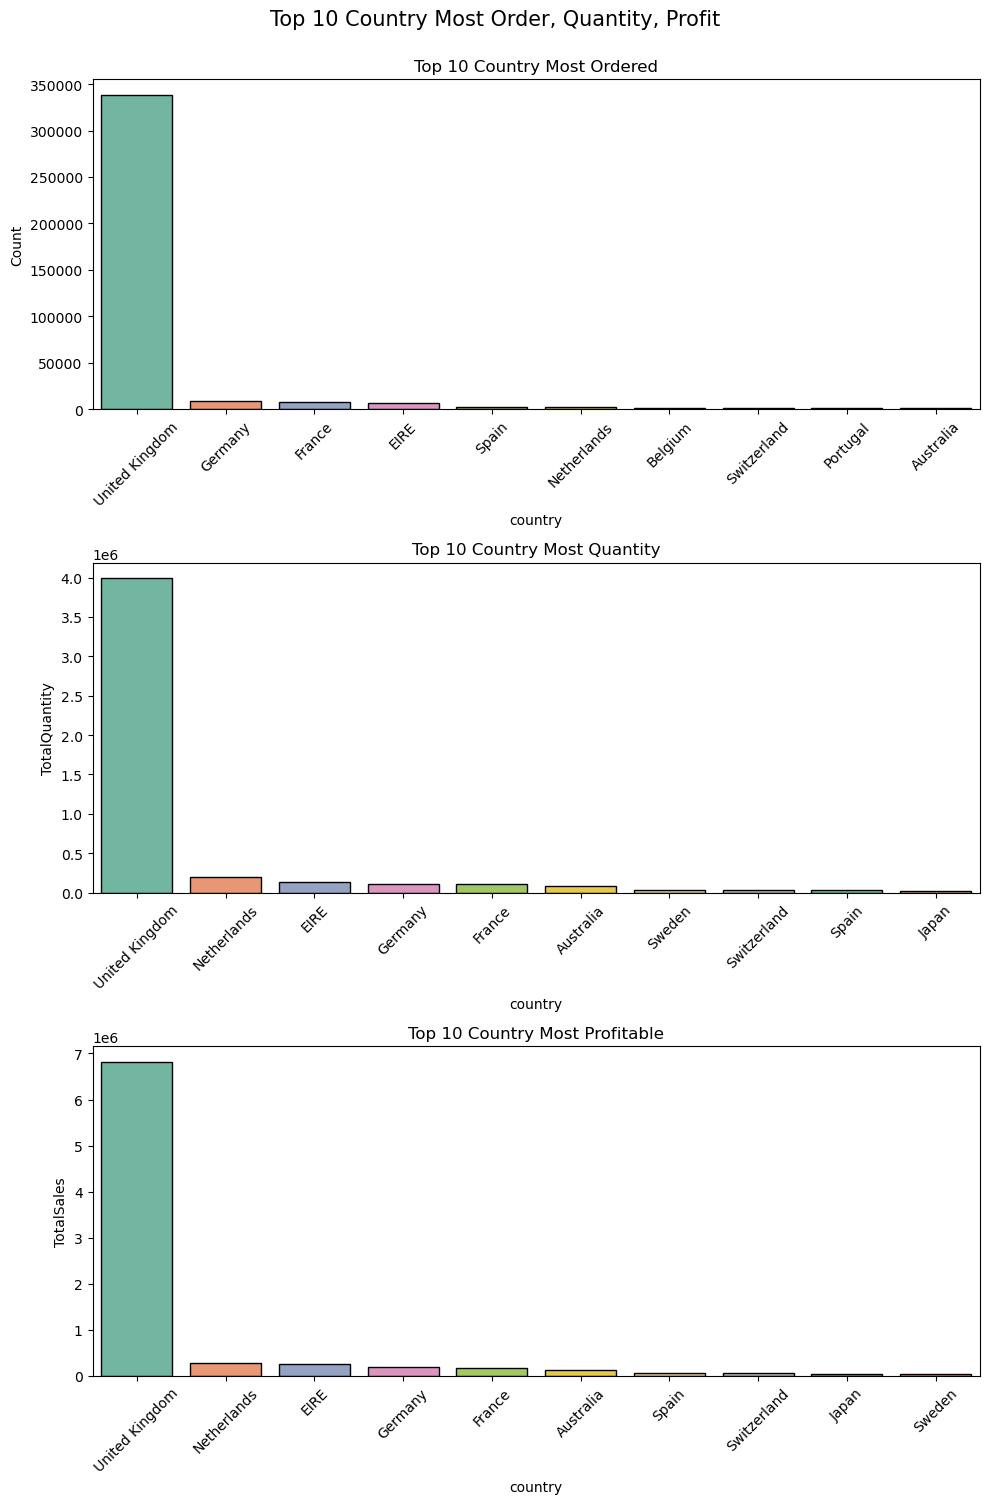

In [16]:
# Group by Country and calculate total quantity
country_order = df.groupBy("country").count().withColumnRenamed("count", "OrderCount")
country_order = country_order.orderBy(f.desc("OrderCount")).limit(10)

# Group by Country and calculate total quantity
country_quantity = df.groupBy("country").sum("quantity").withColumnRenamed("sum(quantity)", "TotalQuantity")
country_quantity = country_quantity.orderBy(f.desc("TotalQuantity")).limit(10)

# Group by Country and calculate total sales
country_profit = df.groupBy("country").sum("TotalSales").withColumnRenamed("sum(TotalSales)", "TotalSales")
country_profit = country_profit.orderBy(f.desc("TotalSales")).limit(10)

# Convert Spark DataFrame to Pandas DataFrame for visualization
country_order_pd = country_order.toPandas()
country_quantity_pd = country_quantity.toPandas()
country_profit_pd = country_profit.toPandas()

# Plotting
plt.figure(figsize=(10, 15), dpi=100)
plt.suptitle("Top 10 Country Most Order, Quantity, Profit", fontsize=15, y=1)

plt.subplot(311)
sns.barplot(data=country_order_pd, x="country", y="OrderCount", palette="Set2", edgecolor='k')
plt.title("Top 10 Country Most Ordered", fontsize=12)
plt.xticks(rotation=45)
plt.ylabel("Count")

plt.subplot(312)
sns.barplot(data=country_quantity_pd, x="country", y="TotalQuantity", palette="Set2", edgecolor='k')
plt.title("Top 10 Country Most Quantity", fontsize=12)
plt.xticks(rotation=45)

plt.subplot(313)
sns.barplot(data=country_profit_pd, x="country", y="TotalSales", palette="Set2", edgecolor='k')
plt.title("Top 10 Country Most Profitable", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Among the 10 countries with the highest frequency of purchases, the United Kingdom stands out as the country with the highest number of orders and most profitable transactions. Therefore, the analysis will focus on the United Kingdom. <br>

Business Insight: The United Kingdom shows significant potential in terms of customer demand and profitability. By concentrating our analysis on this country, we can gain a deeper understanding of the market dynamics, customer behavior, and factors driving profitability. This will enable us to tailor our business strategies and marketing efforts to maximize success in the UK market.

In [17]:
# filter only contain United Kingdom
df_uk = df.filter(col("country") == "United Kingdom")
df_uk.createOrReplaceTempView('table_uk')

## Analysis 2 : Quantity and Total Purchases Grotwh By year

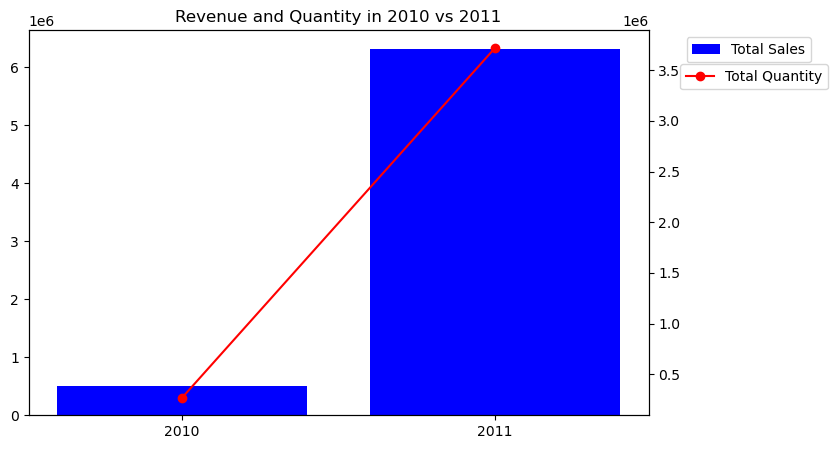

In [18]:
# Calculate total sales and total quantity per year using Spark SQL
qt_pd = spark.sql("""
    SELECT year, SUM(quantity) AS TotalQuantity, SUM(TotalSales) AS TotalSales
    FROM table_uk
    GROUP BY year
    ORDER BY year
""").toPandas()


# Plotting
fig = plt.figure(figsize=(8, 5), dpi=100)
ax1 = plt.subplot(111)
ax1.bar(qt_pd["year"], qt_pd["TotalSales"], color="blue", label="Total Sales")
plt.xticks(qt_pd["year"])
ax2 = ax1.twinx()
ax2.plot(qt_pd["year"], qt_pd["TotalQuantity"], marker="o", color="r", label="Total Quantity")

plt.title("Revenue and Quantity in 2010 vs 2011")
ax1.legend(loc="best", bbox_to_anchor=(1.05, 0.5, 0., 0.5))
ax2.legend(loc="best", bbox_to_anchor=(1.3, 0.5, 0., 0.43))
plt.show()

There has been an increase in total quantity and total sales from 2010 to 2011. Therefore, the subsequent analysis will focus on the year 2011. <br>

Business Insight: The observed growth in both total quantity and sales indicates a positive trend in customer demand and revenue generation. By narrowing our analysis to the year 2011, we can delve deeper into understanding the underlying factors contributing to this growth. This will allow us to identify successful strategies, customer preferences, and market dynamics specific to that year. By leveraging these insights, we can optimize our business operations and marketing strategies to sustain and further enhance the growth trajectory in 2011.

In [19]:
# filter data
df_uk = df_uk.filter(col('year') > 2010)

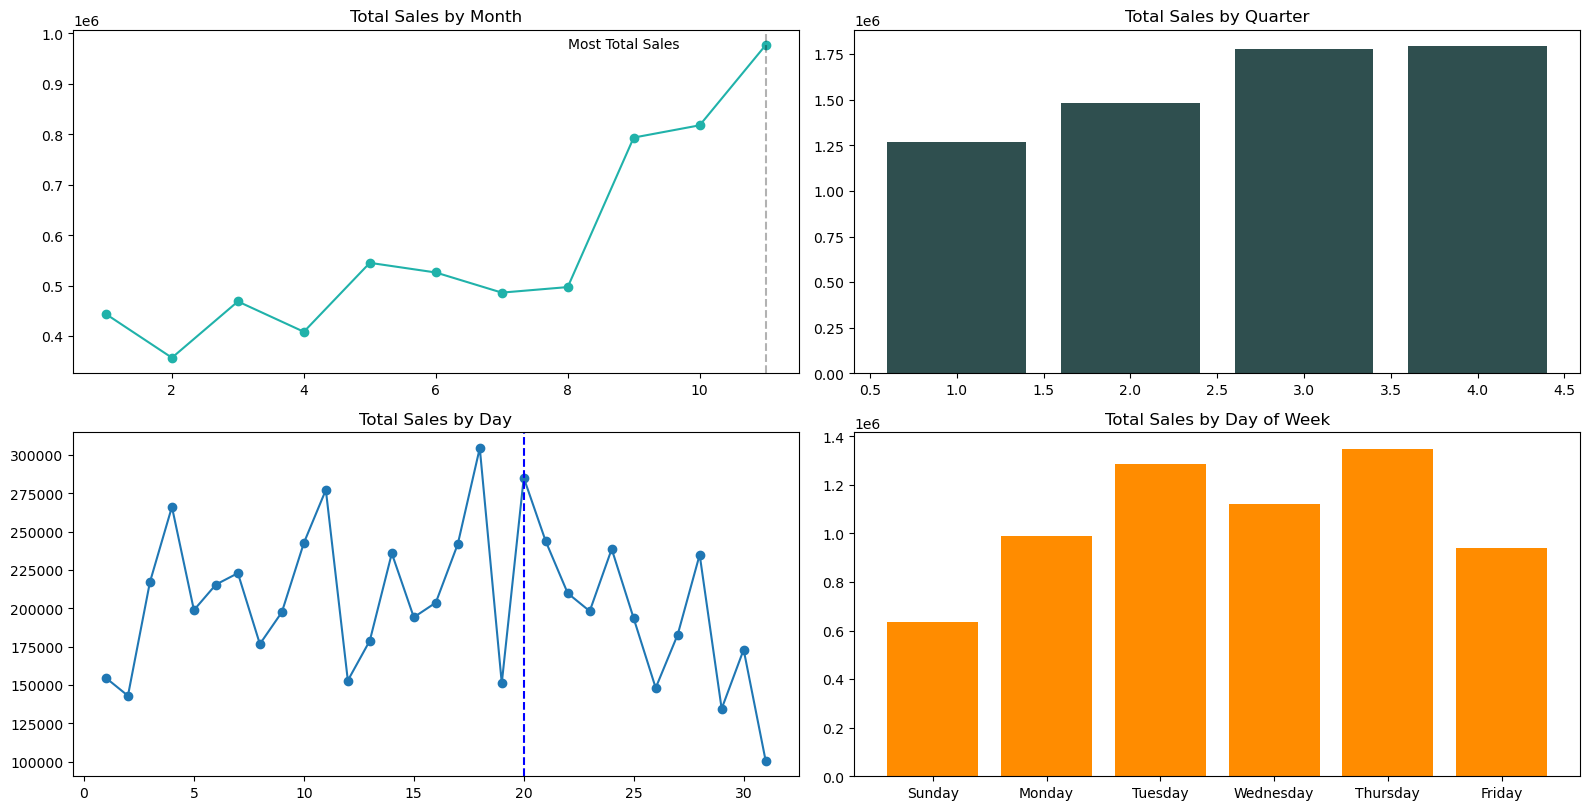

In [20]:
# Calculate total sales by month
total_sales_month = df_uk.groupBy("months") \
    .sum("TotalSales") \
    .orderBy("months") \
    .select("months" , "sum(TotalSales)")


# Calculate total sales by quarter
total_sales_quarter = df_uk.groupBy("quarter") \
    .sum("TotalSales") \
    .orderBy("quarter")

# Calculate total sales by day
total_sales_day = df_uk.groupBy("days") \
    .sum("TotalSales") \
    .orderBy("days")

# Calculate total sales by day of week
total_sales_weekday = df_uk.groupBy("weekdays") \
    .sum("TotalSales") \
    .orderBy("weekdays")\
    .withColumn('weekdays',when(col("weekdays") == 1, "Sunday")
                            .when(col("weekdays") == 2, "Monday")
                            .when(col("weekdays") == 3, "Tuesday")
                            .when(col("weekdays") == 4, "Wednesday")
                            .when(col("weekdays") == 5, "Thursday")
                            .when(col("weekdays") == 6, "Friday")
                            .when(col("weekdays") == 7, "Saturday"))

# Convert Spark DataFrames to Pandas DataFrames
total_sales_month_pd = total_sales_month.toPandas()
total_sales_quarter_pd = total_sales_quarter.toPandas()
total_sales_day_pd = total_sales_day.toPandas()
total_sales_weekday_pd = total_sales_weekday.toPandas()


# Plotting the data
plt.figure(figsize=(16, 12))

plt.subplot(3, 2, 1)
plt.plot(total_sales_month_pd['months'], total_sales_month_pd['sum(TotalSales)'], marker='o', color='lightseagreen')
plt.axvline(11, color='k', linestyle='--', alpha=0.3)
plt.text(8, 0.97e6, "Most Total Sales")
plt.title("Total Sales by Month")

plt.subplot(3, 2, 2)
plt.bar(total_sales_quarter_pd['quarter'], total_sales_quarter_pd['sum(TotalSales)'], color='darkslategrey')
plt.title("Total Sales by Quarter")

plt.subplot(3, 2, 3)
plt.plot(total_sales_day_pd['days'], total_sales_day_pd['sum(TotalSales)'], marker='o')
plt.axvline(x=20, linestyle="--", color='blue')
plt.title("Total Sales by Day")

plt.subplot(3, 2, 4)
plt.bar(total_sales_weekday_pd['weekdays'], total_sales_weekday_pd['sum(TotalSales)'], color='darkorange')
plt.title("Total Sales by Day of Week")

plt.tight_layout()
plt.show()

1. Sales growth significantly increased after the 8th month, with the peak increase occurring in the 11th month.

Business Insight: The observed significant growth in sales after the 8th month indicates the effectiveness of certain strategies or events that positively impacted customer demand. Identifying the factors contributing to this growth can help replicate successful initiatives in the future and capitalize on peak sales periods in the 11th month. 

2. Sales growth by quarter shows an increasing trend.

Business Insight: The increasing trend in sales growth by quarter indicates a positive overall performance and market demand throughout the year. This trend suggests that the business strategies implemented during each quarter were successful in driving sales. Analyzing the specific factors contributing to the growth in each quarter can provide valuable insights for planning and optimizing future strategies.

3. Analysis of total sales based on dates shows fluctuating growth until the 20th day, followed by a decline.

Business Insight: The fluctuating growth in total sales until the 20th day suggests that certain factors, such as promotions, events, or customer behavior, influenced sales positively during that period. However, the subsequent decline indicates a decrease in sales growth. Further analysis can be conducted to identify the reasons behind the decline and determine appropriate actions to address it.

4. Sales growth based on weekdays shows an increasing trend from Sunday to Thursday, followed by a decrease on Friday.

Business Insight: The increasing trend in sales from Sunday to Thursday indicates consistent customer demand and successful business operations during weekdays. However, the observed decrease in sales on Friday suggests a potential opportunity for improvement. Analyzing the reasons behind the decline on Fridays, such as customer behavior patterns or market dynamics, can help identify strategies to boost sales and maximize revenue on that particular day.

In [21]:
# Filter data for November
df_november = df_uk.filter(col("months") == 11)

# Group by description and calculate total quantity sold
product_sales_november = df_november.groupBy("Description").agg({"Quantity": "sum", "TotalSales": "sum","unitprice":"mean"}) \
    .withColumnRenamed("sum(Quantity)", "TotalQuantity") \
    .withColumnRenamed("sum(TotalSales)", "TotalSales") \
    .withColumnRenamed("avg(unitprice)","MeanPrice")\
    .orderBy(desc("TotalQuantity"), desc("TotalSales"),desc("MeanPrice"))


# Show the top products sold in November
product_sales_november.show()

+--------------------+-------------+----------+-------------------+
|         Description|TotalQuantity|TotalSales|          MeanPrice|
+--------------------+-------------+----------+-------------------+
|      POPCORN HOLDER|         8036|    6147.0| 0.8434343434343408|
|  RABBIT NIGHT LIGHT|         6179|   11944.0| 2.0363333333333395|
|PAPER CHAIN KIT 5...|         5644|   15416.0|  2.931754385964925|
|JUMBO BAG RED RET...|         5341|   10082.0| 2.0754040404040386|
|ASSORTED COLOUR B...|         4838|    7741.0| 1.6827272727272709|
|WOODEN STAR CHRIS...|         4432|    1318.0|0.32085714285714256|
|WOODEN HEART CHRI...|         4299|    1279.0|0.32051546391752506|
|DISCO BALL CHRIST...|         4271|     475.0|0.11836065573770499|
|WHITE HANGING HEA...|         4199|   12150.0|  2.945045454545455|
|WORLD WAR 2 GLIDE...|         4068|    1175.0| 0.3088235294117642|
|SMALL CHINESE STY...|         3546|    1138.0|0.39777777777777773|
|PAPER CHAIN KIT V...|         3142|    8562.0| 

In the month of November, a significant number of high-priced items were sold, resulting in high total sales.

Business Insight: The observation that a large quantity of high-priced items were sold in November indicates a potential opportunity for increased revenue and profitability. This suggests that customers were willing to make higher-value purchases during this period, which positively impacted the total sales figure. Understanding the factors that contributed to the sale of higher-priced items in November can help in developing targeted marketing strategies and product offerings to capitalize on this trend in future months or seasons. It is important to analyze the specific products or promotions that drove this increase in sales to replicate their success and maximize revenue potential.

## Analysis 4 : Statistics Correlation Quantity and Unit Price

In [22]:
# Calculate Pearson's correlation coefficient between Quantity and UnitPrice
correlation = df_uk.select(corr("Quantity", "UnitPrice")).collect()[0][0]

print("The Pearson's Correlation Coefficient is:", '{:.2f}'.format(correlation))

The Pearson's Correlation Coefficient is: -0.02


The correlation between quantity and unit price is weak and negatively correlated, indicating that higher prices can lead to lower quantities sold. As the price increases, the demand decreases.

Business Insight: The observed weak and negative correlation between quantity and unit price suggests that pricing plays a crucial role in determining customer demand. When the unit price is set too high, it can discourage customers from making purchases, resulting in lower quantities sold. It is important for businesses to carefully consider pricing strategies to find the right balance between maximizing profitability and ensuring sufficient customer demand. By analyzing pricing data and customer behavior, businesses can identify optimal price points that drive sales volume while maintaining competitive pricing.

## Analysis 5 : Repeated Customer

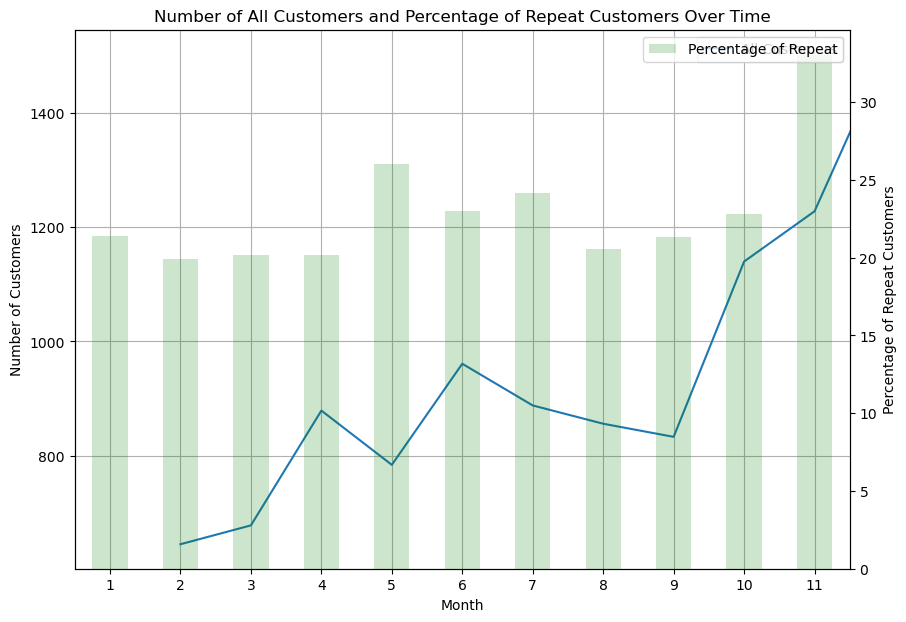

In [23]:
# Convert InvoiceDate column to date type
df_uk = df_uk.withColumn("InvoiceDate", to_date(col("InvoiceDate")))

# Group by InvoiceNo and InvoiceDate, and aggregate TotalSales and CustomerID
invoice_customer = df_uk.groupBy("InvoiceNo", "InvoiceDate").agg(
    sum("TotalSales").alias("TotalSales"),
    max("customerid").alias("CustomerID")
)

# Calculate the count of repeat customers per month
window_spec = Window.partitionBy(year("InvoiceDate").alias("Year"), month("InvoiceDate").alias("Month")).orderBy("CustomerID")
monthly_repeat = invoice_customer.groupBy(year("InvoiceDate").alias("Year"), month("InvoiceDate").alias("Month"), "CustomerID") \
    .agg(countDistinct("InvoiceNo").alias("InvoiceCount")) \
    .filter(col("InvoiceCount") > 1) \
    .groupBy("Year", "Month") \
    .agg(countDistinct("CustomerID").alias("RepeatCustomers"))

# Calculate the count of unique customers per month
monthly_unique_customers = df_uk.groupBy(year("InvoiceDate").alias("Year"), month("InvoiceDate").alias("Month")) \
    .agg(countDistinct("CustomerID").alias("AllCustomers"))

# Calculate the percentage of repeat customers
monthly_repeat_percentage = monthly_repeat.join(monthly_unique_customers, ["Year", "Month"], "inner") \
    .withColumn("RepeatPercentage", (col("RepeatCustomers") / col("AllCustomers")) * 100)

# Convert Spark DataFrame to Pandas DataFrame for plotting
monthly_repeat_pd = monthly_repeat.select("Year", "Month", "RepeatCustomers").toPandas()
monthly_unique_customers_pd = monthly_unique_customers.select("Year", "Month", "AllCustomers").toPandas().sort_values("Month",ascending=True)
monthly_repeat_percentage_pd = monthly_repeat_percentage.select("Year", "Month", "RepeatPercentage").toPandas().sort_values("Month",ascending=True)

# Plot the number of customers over time
fig, ax1 = plt.subplots(figsize=(10, 7))
ax2 = ax1.twinx()

monthly_unique_customers_pd.plot(x="Month", y="AllCustomers", ax=ax1, legend=False, grid=True)
monthly_repeat_percentage_pd.plot(x="Month", y="RepeatPercentage", kind="bar", ax=ax2, legend=False, color="green", alpha=0.2)

ax1.set_xlabel("Month")
ax1.set_ylabel("Number of Customers")
ax2.set_ylabel("Percentage of Repeat Customers")

ax1.legend(["All Customers"])
ax2.legend(["Percentage of Repeat"], loc="upper right")

plt.title("Number of All Customers and Percentage of Repeat Customers Over Time")
plt.xticks(rotation=45)

plt.show()


Based on the analysis, we can observe that the trend of customers placing repeated orders exhibits a seasonal pattern in terms of quantity. There is a cycle of approximately three months where the number of repeated orders increases and then decreases again. However, when considering the percentage of total customers, there is an overall increasing trend, despite a slight decrease in the 9th month.

Additionally, we can infer why there is an increase in total sales in the month of November.

Business Insight: The seasonal pattern in the quantity of repeated orders suggests that customers tend to make repeat purchases in cycles of approximately three months. This information can be valuable in planning marketing campaigns or promotions targeted at encouraging repeat purchases during specific periods.

Furthermore, the increasing trend in the percentage of total customers indicates a positive growth in customer loyalty and retention over time, even though there might be slight fluctuations in certain months. This emphasizes the importance of building strong relationships with customers and implementing effective customer retention strategies.

The increase in total sales in November can be attributed to various factors. It is crucial to further analyze the specific reasons behind this increase, such as seasonal demand, holiday promotions, or special events. By understanding the factors driving the growth in sales during November, businesses can optimize their strategies and offerings to replicate or enhance this success in subsequent months or during similar periods.

Overall, a comprehensive analysis of customer behavior, including the trends in repeated orders and total customer percentage, can provide valuable insights for strategic decision-making, customer retention efforts, and maximizing sales opportunities during specific months or seasons.